# GNILC Dust templates for PySM 3
> Dust templates based on Planck GNILC maps in logarithmic polarization fraction formalism (logpoltens) with injection of simulated small scale fluctuations

In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

Make sure we run namaster in the notebook

In [2]:
!rm data/*.npz

rm: cannot remove 'data/*.npz': No such file or directory


In [3]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [4]:
hp.__version__

'1.15.0'

NaMaster from conda forge 1.2.2

In [5]:
from importlib.metadata import version

In [6]:
plt.style.use("seaborn-talk")

In [7]:
import pysm3 as pysm
import pysm3.units as u

In [8]:
nside = 2048
lmax = int(2048 * 1.5)

In [9]:
comp = "IQU"

In [10]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [11]:
spectra_components = ["TT", "EE", "BB"]

change this to True   if you want to  run namaster on notebook 


In [12]:
namaster_on_nb = True

In [13]:
datadir=Path("data/")

## Dust maps 
- We use the  2015 GNILC intensity map from the 2nd planck release, as it encodes less contamination from CIB with 21.8' resolution

- for Q and U we adopt maps from the 3rd Planck release as they were optimized for polarization studies with 80' reso.  



In [14]:
dust_varresI = datadir / "COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits"
dust_varresP = datadir / "COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits"

In [15]:
if not dust_varresI.exists():
    !wget -O $dust_varresI https://portal.nersc.gov/project/cmb/pysm-data/gnilc/inputs/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits

In [16]:
if not dust_varresP.exists():
    !wget -O $dust_varresP http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits

Transform maps to double precision for computations

In [17]:
m_planck_varres, h = hp.read_map(dust_varresP, [c + "_STOKES" for c in comp], dtype=np.float64, h=True)
I_planck_varres, h = hp.read_map(dust_varresI, dtype=np.float64, h=True)

Maps from the two releases are in different units `MJy/sr` the former, and `K_CMB` the latter, we therefore need to perform some conversion to `uK_RJ`. 

In [18]:
m_planck_varres <<= u.K_CMB
I_planck_varres <<= u.MJy / u.sr
m_planck_varres = m_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)
I_planck_varres = I_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

then we are ready to combine both maps into one single TQU map. 

In [19]:
m_planck_varres[0] = I_planck_varres
del I_planck_varres

In [20]:
m_planck_varres.dtype

dtype('float64')

### GAL080 Planck  mask 

we mask the galaxy to estimate the power spectra with Namaster before and after small scale injection. 


In [21]:
planck_mask_filename = datadir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

if not planck_mask_filename.exists():
    !wget -O $planck_mask_filename "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

masking 0.7912631829579672 of the sky


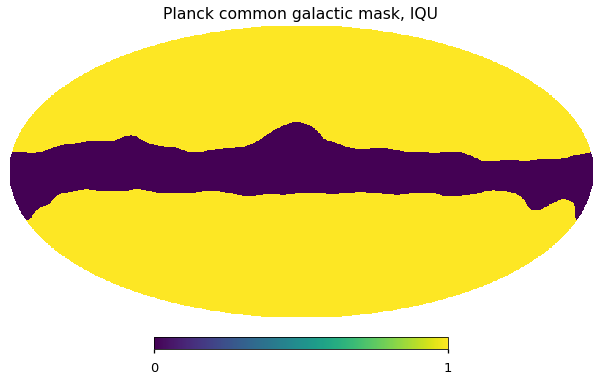

In [22]:
planck_mask = hp.read_map(planck_mask_filename, ["GAL080"])

planck_mask = np.int_(np.ma.masked_not_equal(planck_mask, 0.0).mask)
fsky = planck_mask.sum() / planck_mask.size
print(f"masking {fsky} of the sky")
hp.mollview(planck_mask, title=f"Planck common galactic mask, {comp}")

#### Monopole subtraction 


Section 2.2 of [Planck 2018 XII](https://arxiv.org/pdf/1807.06212.pdf) value reported:  0.13 MJy/sr 

we subtract this term only to the I map for   the pixels outside  the Galactic plane mask.

In [23]:
planck2018_monopole = (0.13 * u.MJy / u.sr).to(
    u.uK_RJ, equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

m_planck_varres[0][planck_mask] -= planck2018_monopole


We estimate how many pixels have I< P after we subtract the monopole 

In [24]:
maskmono = m_planck_varres[0] ** 2 < m_planck_varres[1] ** 2 + m_planck_varres[2] ** 2
print(
    f"{maskmono.sum() } pixels out of { maskmono.size} expected to be NaNs in Log Pol Tens maps "
)

5 pixels out of 50331648 expected to be NaNs in Log Pol Tens maps 


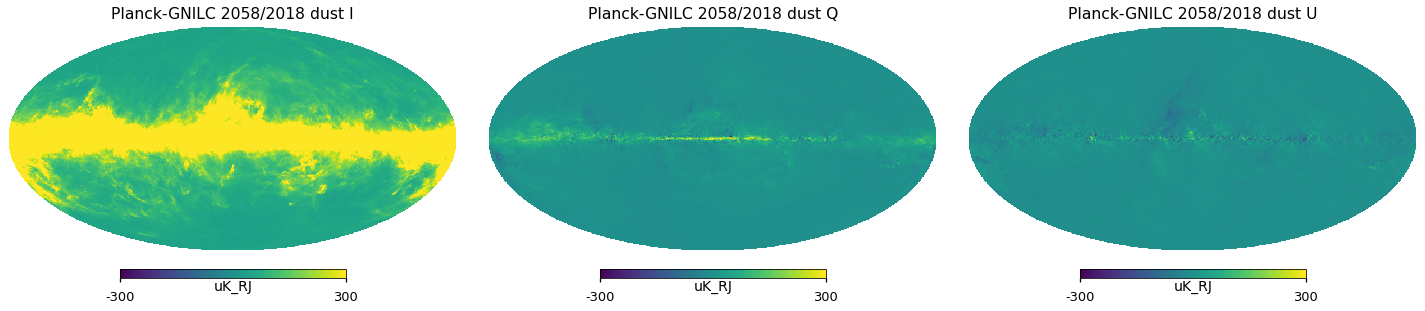

In [25]:
plt.figure(figsize=(20, 5))
for i_pol, pol in components:
    hp.mollview(
        m_planck_varres[i_pol],
        title="Planck-GNILC 2058/2018 dust " + pol,
        sub=131 + i_pol,
        unit=m_planck_varres.unit,
        min=-300,
        max=300,
    )

## Transform maps to Poltens quantities 

In [26]:
def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i = np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))

In [27]:
log_pol_tens_varres = map_to_log_pol_tens(m_planck_varres.value)

/tmp/ipykernel_53003/1566809701.py:4: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
/tmp/ipykernel_53003/1566809701.py:5: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


check the transformation back and forth 

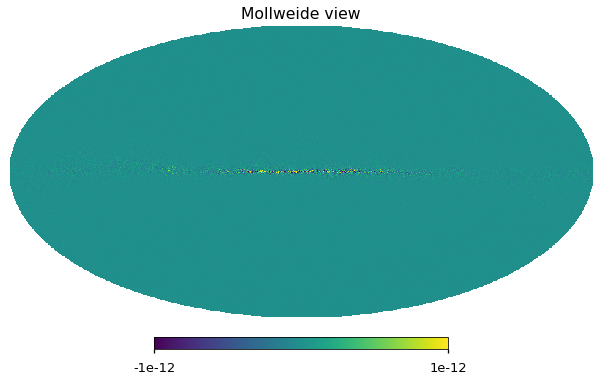

In [28]:
m_back = log_pol_tens_to_map(log_pol_tens_varres)
hp.mollview((m_planck_varres.value - m_back)[1], min=-1e-12, max=1e-12)
del m_back

Checking NaNs  on the Poltens map 

In [29]:
print(
    f"{np.isnan(log_pol_tens_varres[0]).sum()  } pixels out of { maskmono.size} are NaNs in Log Pol Tens maps "
)

5 pixels out of 50331648 are NaNs in Log Pol Tens maps 


In [30]:
for i in range(3):
    log_pol_tens_varres[i, np.isnan(log_pol_tens_varres[i])] = np.nanmedian(
        log_pol_tens_varres[i]
    )

Set all the NaNs to the map median value  


In [31]:
assert np.isnan(log_pol_tens_varres).sum() == 0

In [32]:
hp.write_map(
    datadir / "dust_gnilc_logpoltens_varres_nomono.fits",
    log_pol_tens_varres,
    dtype=np.float32,
    overwrite=True,
)

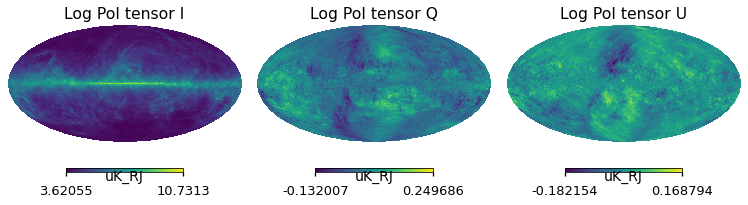

In [33]:
for i_pol, pol in components:
    hp.mollview(
        log_pol_tens_varres[i_pol],
        title="Log Pol tensor " + pol,
        sub=131 + i_pol,
        unit=m_planck_varres.unit,
    )

In [34]:
from scipy.optimize import curve_fit

In [35]:
def model(ell, A, gamma):
    out = A * ell ** gamma
    out[:2] = 0
    return out

In [36]:
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]
    cl["TE"] = clanaf[3]
    ell = np.arange(lmax + 1)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


def run_namaster(m, mask, lmax, nlbins=1):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """
    nside = hp.npix2nside(len(mask))

    binning = nmt.NmtBin(nside=nside, nlb=nlbins, lmax=lmax, is_Dell=False)

    cl = {}

    f_0 = nmt.NmtField(mask, [m[0].copy()])

    if len(m) == 3:
        f_2 = nmt.NmtField(mask, m[1:].copy())  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [37]:
print("run anafast on masked sky  ")
ell, cl_norm, cl = run_anafast(log_pol_tens_varres, lmax)

run anafast on masked sky  


## Fitting the power law from the fullsky power spectra  

We firstly fit a power law spectrum in different multipole ranges.
As we get flatter spectral indices for polarization spectra,  this will yield to  injecting smaller angular scales in TT whose power at given multipole $\ell_*$  is smaller than EE and BB for all $\ell>\ell_*$. 
To avoid this we therefore force EE and BB small scales to follow the fitted TT power law. We also remark  that in this way we get EB ratio closer to ~2.  


Spectral index from fit for TT=-1.287281949352306
Spectral index from fit for EE=-0.33416164389836966
Spectral index from fit for BB=-0.4011846420020595
B-to-E ratio w/ fitted power law at l= 110 , 0.8185189913140243
B-to-E ratio w/ TT power law at l= 110 , 0.5973219886564932


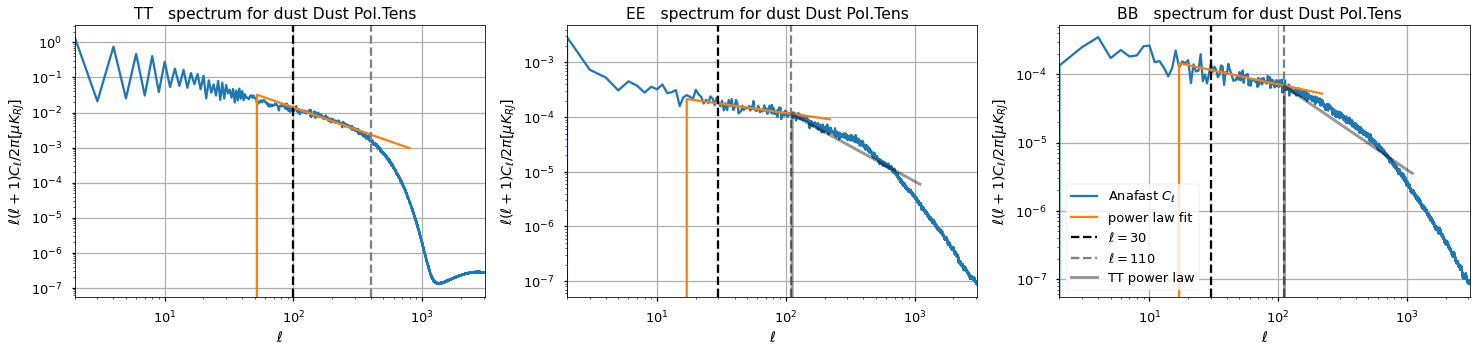

In [38]:
ell_fit_low = {"TT":100, "EE":30, "BB":30}
ell_fit_high = {"TT":400, "EE":110, "BB":110}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
plt.figure(figsize=(25,5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))

    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="Anafast $C_\ell$")
    plt.plot(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], 
             model(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], A_fit[pol], gamma_fit[pol]), label="power law fit")
    
    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.grid()
    plt.title(f"{pol}   spectrum for dust Dust Pol.Tens  " )

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    print(f"Spectral index from fit for {pol}={gamma_fit[pol]}")
print(f"B-to-E ratio w/ fitted power law at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}" ) 

for ii, pol in enumerate(spectra_components[1:] ):
    #we change the EE and BB power laws 
    A_fit[pol] =A_fit[pol]*  ell_fit_high[pol]**( gamma_fit[pol ] - gamma_fit['TT' ] ) 
    gamma_fit[pol] = gamma_fit['TT'] 
    plt.subplot(132+ii)
    plt.plot(ell[ell_fit_high[pol] :ell_fit_high[pol]*10], 
             model(ell[ell_fit_high[pol]:ell_fit_high[pol]*10], A_fit[pol], gamma_fit[pol]),linewidth=3, alpha=.4, color='k', 
             label="TT power law")
    
print(f"B-to-E ratio w/ TT power law at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}" ) 
plt.legend()

### Define Modulation maps 
as the injected small scales are at different multipoles for intensity and polarization, we consider 2 different modulation maps  

#### Modulation for  polarization : 
- smooth `i` map to 5 deg 
- we saturate all the pixels >4.5 to 1.1 
- reduce the dynamic range to range from .1 to 1.1 with MinMax rescaling  

#### Modulation for  intensity : 
- smooth `i` map to 5 deg 
- for  the pixels >4.5  MinMax rescaling from 1.1 to 2 
- elsewhere MinMax rescaling  from  .1 to 1.1   

In [39]:
ismooth = hp.smoothing(log_pol_tens_varres[0], fwhm=np.radians(5), lmax=lmax)

In [40]:
b1 = 1.1
b2 = 2
a = 0.1
minmax = lambda m, a, b: a + (b - a) * (m - m.min()) / (m.max() - m.min())

modulate_amp_pol = (ismooth) * 1.0
modulate_amp = (ismooth) * 1.0
val = 4.5
mskmd = ismooth > val
modulate_amp_pol[mskmd] = b1

modulate_amp_pol[~mskmd] = minmax(ismooth[~mskmd], a=a, b=b1)

modulate_amp[mskmd] = minmax(ismooth[mskmd], a=b1, b=b2)

modulate_amp[~mskmd] = minmax(ismooth[~mskmd], a=a, b=b1)

In [41]:
del ismooth, mskmd

In [42]:
# hp.write_map(datadir / f"modulate_amp_nside{nside}.fits", modulate_amp, dtype=np.float32, overwrite=True)
# hp.write_map(
#    datadir / f"modulate_amp_pol_nside{nside}.fits", modulate_amp_pol, dtype=np.float32, overwrite=True
# )

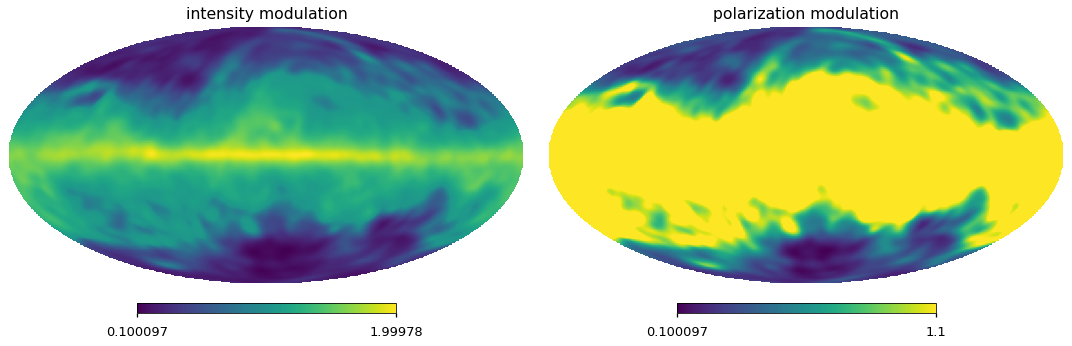

In [43]:
plt.figure(figsize=(15, 5))
hp.mollview(modulate_amp, title="intensity modulation", sub=121)
hp.mollview(modulate_amp_pol, title="polarization modulation", sub=122)

In [44]:
modulate_alm = {}
for name, each_modulate in [("temperature", modulate_amp), ("polarization", modulate_amp_pol)]:
    modulate_alm[name] = hp.map2alm(each_modulate, lmax=1.5 * nside, use_pixel_weights=True)
    hp.write_alm(datadir / f"gnilc_dust_{name}_modulation_alms_lmax{int(1.5*nside):d}.fits",
             modulate_alm[name], overwrite=True, out_dtype=np.float32)
del modulate_amp, modulate_amp_pol, each_modulate

### Making maps with small scales 
1. generate the Cl  from the fit power spectra and with the sigmoid high-pass filter 
2. construct Alm  from the Cl 
3. Filter Alm encoding  small scales with the  sigmoid 
4. Estimate Alm of the fullsky poltens maps encoding large scales  with the sigmoid low-pass filter ,  
5. Estimate maps from the Alm with large and small scales , `ls` and `ss` 
6. modulate small scales with modulation maps , i.e. `ss' =ss * modulation_maps` 
7. define new poltens maps as : `iqu = ls +ss'` 
8.  transform back to real `IQU` maps

### Prepare output maps

The notebook is executed at $N_{side}=2048$ for documentation and then at 8192 to produce the output map.

In [45]:
output_nside = 2048 #8192
output_lmax = 2 * output_nside
output_ell = np.arange(output_lmax + 1)
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2
output_cl_norm[0] = 1

In [46]:
# filter small scales
small_scales_input_cl = [
    1
    * model(output_ell, A_fit[pol], gamma_fit[pol])
    * sigmoid(output_ell, ell_fit_high[pol], ell_fit_high[pol] / 10)
    / output_cl_norm
    for pol in spectra_components
]
hp.write_cl(
    datadir / f"gnilc_dust_small_scales_logpoltens_cl_lmax{output_lmax}.fits",
    small_scales_input_cl,
    dtype=np.complex128,
    overwrite=True,
)
alm_log_pol_tens_fullsky = hp.map2alm(
    log_pol_tens_varres, lmax=lmax, use_pixel_weights=True
)

ii_LS_alm = np.empty_like(alm_log_pol_tens_fullsky)
for ii, pol in enumerate(spectra_components):

    sig_func = sigmoid(ell, x0=ell_fit_high[pol], width=ell_fit_high[pol] / 10)

    ii_LS_alm[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii], (1.0 - sig_func) ** 0.2)

np.random.seed(8192)

log_ss_alm = hp.synalm(
    small_scales_input_cl + [np.zeros_like(small_scales_input_cl[0])] * 3,
    lmax=output_lmax,
    new=True,
)
log_ss = hp.alm2map(log_ss_alm, nside=output_nside)
assert np.isnan(log_ss).sum() == 0
modulate_amp = hp.alm2map(modulate_alm["temperature"], output_nside)
log_ss[0] *= modulate_amp
modulate_amp_pol = hp.alm2map(modulate_alm["polarization"], output_nside)
log_ss[1:] *= modulate_amp_pol
assert np.isnan(log_ss).sum() == 0
largescale_lmax = min(int(1.5*nside), output_nside)
hp.write_alm(
    datadir / f"gnilc_dust_largescale_template_logpoltens_alm_nside{nside}_lmax{largescale_lmax:d}_complex64.fits",
    ii_LS_alm,
    lmax=largescale_lmax,
    out_dtype=np.complex64,
    overwrite=True,
)
log_ls = hp.alm2map(ii_LS_alm, nside=output_nside)
ii_map_out = log_ss + log_ls

/tmp/ipykernel_53003/3589521984.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


In [47]:
del log_ls, ii_LS_alm

In [48]:
output_map = log_pol_tens_to_map(ii_map_out)

hp.write_map(
    datadir / f"gnilc_dust_template_nside{output_nside}_float32.fits",
    output_map,
    dtype=np.float32,
    overwrite=True,
)

In [49]:
output_map_alm = hp.map2alm(output_map, lmax=output_lmax)

In [50]:
hp.write_alm(
    datadir / f"dust_gnilc_template_alm_nside{output_nside}_lmax{output_lmax}_complex64.fits",
    output_map_alm,
    out_dtype = np.complex64,
    overwrite=True,
)

#### Plot maps 

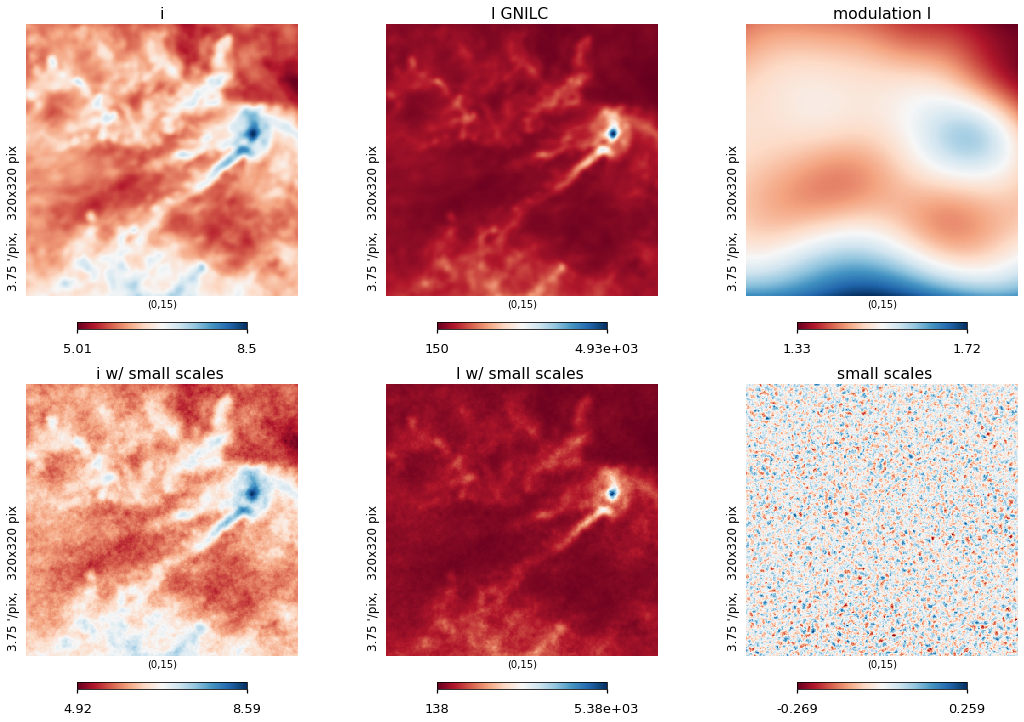

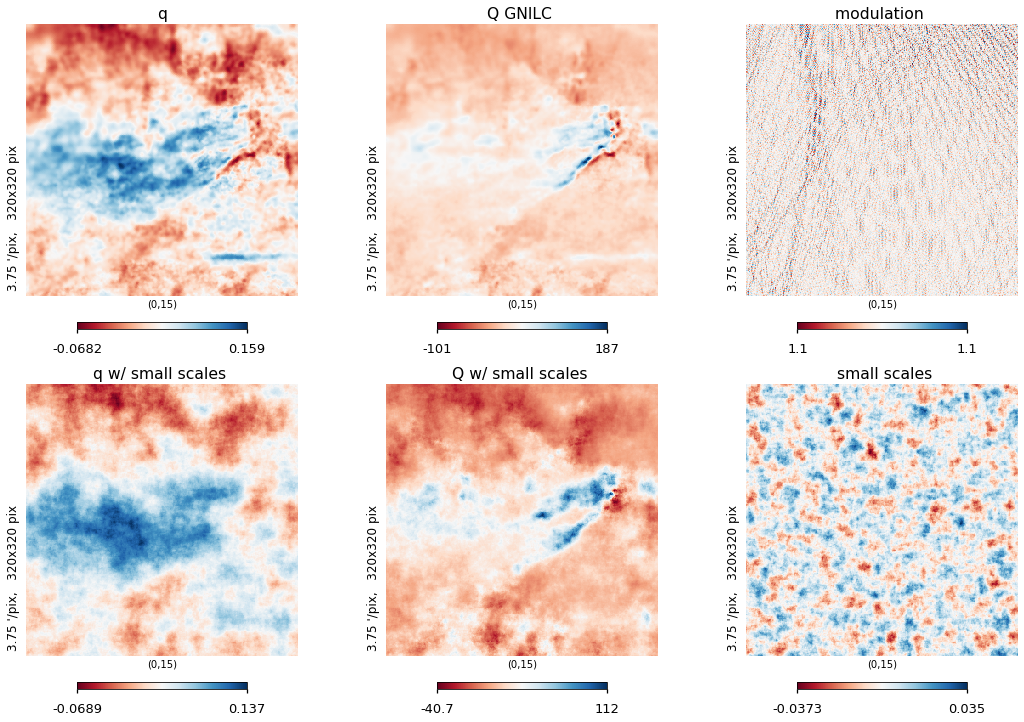

In [51]:
lat=15
plt.figure(figsize=(15,10))
hp.gnomview(ii_map_out[0] ,cmap='RdBu',   title='i w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=234 )
hp.gnomview(log_pol_tens_varres [0],cmap='RdBu',  title='i', rot=[0,lat],reso=3.75,xsize=320, sub=231 )
hp.gnomview((modulate_amp),cmap='RdBu',  title=' modulation I ', rot=[0,lat],reso=3.75,xsize=320,  sub=233, )

hp.gnomview((m_planck_varres [0]),cmap='RdBu',  title=' I GNILC  ', rot=[0,lat],reso=3.75,xsize=320,  sub=232, )
hp.gnomview((log_ss)[0],cmap='RdBu',  title='  small scales ', rot=[0,lat], reso=3.75,xsize=320, sub=236, )
hp.gnomview(output_map[0],cmap='RdBu' ,  title='I w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=235 )

plt.figure(figsize=(15,10))
hp.gnomview(ii_map_out[1],cmap='RdBu' ,  title='q w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=234 )
hp.gnomview(log_pol_tens_varres [1],cmap='RdBu',  title='q', rot=[0,lat],reso=3.75,xsize=320, sub=231 )
hp.gnomview((modulate_amp_pol),cmap='RdBu',  title=' modulation  ', rot=[0,lat],reso=3.75,xsize=320,  sub=233, )

hp.gnomview((m_planck_varres [1]),cmap='RdBu',  title=' Q GNILC  ', rot=[0,lat],reso=3.75,xsize=320,  sub=232, )
hp.gnomview((log_ss)[1],cmap='RdBu',  title='  small scales ', rot=[0,lat], reso=3.75,xsize=320, sub=236, )
hp.gnomview(output_map[1] ,cmap='RdBu',  title='Q w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=235 )



In [52]:
del log_ss, ii_map_out, modulate_amp, modulate_amp_pol

In [53]:
spectra_components += ["TE"]

In [54]:
output_planck_mask = hp.ud_grade(planck_mask, output_nside)

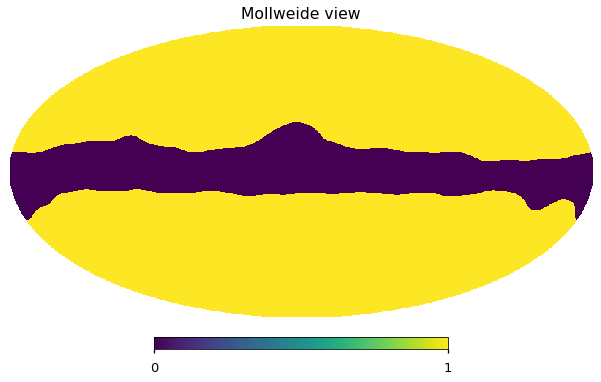

In [55]:
hp.mollview(output_planck_mask)

## Validate outputs estimating NaMaster power spectra on both input and outputs  

we have expanded our validation by means of 3 figures of merit: 

1. TT,EE, BB  power spectra with Namaster 
2. B-to-E ratio  
3. Polarization  fraction 

Moreover, we have considered 4   masks to evaluate the quality of the small scales injected for different $f_{sky} = 0.02,0.2, 0.4,0.8 $. 

Another small difference with previous analysis is that  we estimated the spectra on binned equally-spaced multipoles. We choose $\Delta \ell =35, 25,15,4$   respectively for the 4 masks. 

In [56]:
bk15_mask_filename = datadir/ "BK15_region_Gal_apo.fits"
if not bk15_mask_filename.exists():
    !wget -O $bk15_mask_filename https://portal.nersc.gov/project/cmb/pysm-data/gnilc/inputs/BK15_region_Gal_apo.fits

In [57]:
planck_masks = {k.lower():hp.read_map(datadir/ "HFI_Mask_GalPlane-apo2_2048_R2.00.fits", [k]) for k in ["GAL{:03d}".format(frac) for frac in [20,40,80]]}

planck_masks["BK"] = hp.read_map(bk15_mask_filename)

#planck_masks ={ k:np.ma.masked_equal(m ,  1 ).mask  for k,m in planck_masks.items() } 

In [58]:
nlb= {'BK':35, 'gal020':25, 'gal040':15,'gal080':4 } 

In [59]:
import pymaster as nmt

run Namaster  
run Namaster  


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


run Namaster  
run Namaster  


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


run Namaster  
run Namaster  


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


run Namaster  
run Namaster  


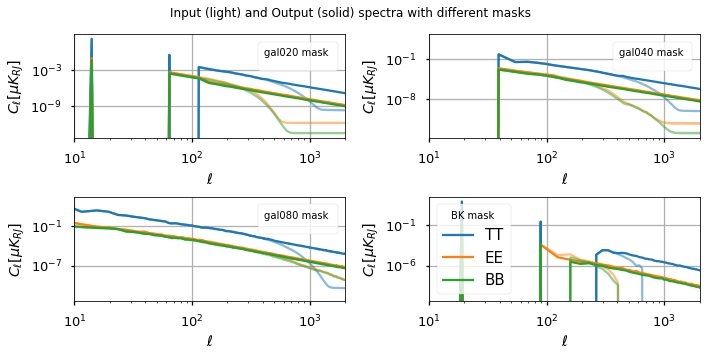

In [60]:
fig = plt.figure(figsize=(10,5))
for jj, k in enumerate(planck_masks.keys())  :
    output_planck_mask= hp.ud_grade(planck_masks[k], nside_out=output_nside)  
    planck_mask= planck_masks[k]
    fspectra = datadir / f"dust_gnilc_hybrid_out_nside2048_float32_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        output_ell, output_cl_norm, cl_out = run_namaster(
            output_map, mask=output_planck_mask, lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=output_ell, cl_norm=output_cl_norm, **cl_out)        
        
    #else:
    #    print("run anafast on masked sky  ")
    #    output_ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)
    
    fspectra = datadir / f"dust_gnilc_varres_no_monopole_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        input_ell = np.load(fspectra)["ell"]
        cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        input_ell, input_cl_norm, cl_in  = run_namaster(
            m_planck_varres, mask=planck_mask, lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=input_ell, cl_norm=input_cl_norm, **cl_in)        
    #else:
    #    print("run anafast on masked sky  ")
    #    ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)
    plt.subplot(2,2,jj+1 )
    for ii, pol in enumerate(["TT","EE", "BB" ]):
        if jj==3:

            plt.loglog(output_ell,  cl_out [pol],   color='C%d'%ii,   label=pol
                 )
        else: 
            plt.loglog(output_ell,  cl_out [pol],   color='C%d'%ii, )             
        plt.loglog(input_ell,   cl_in [pol], color='C%d'%ii,alpha=.5,)

        plt.grid()
        plt.legend(title=(k +" mask "), fontsize=15)  
        plt.ylabel("$ C_\ell  [\mu K_{RJ}]$")
        plt.xlabel(("$\ell$"))
        plt.xlim(10,2e3) 
fig.suptitle("Input (light) and Output (solid) spectra with different masks");
plt.tight_layout()


/tmp/ipykernel_53003/4109047695.py:37: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
/tmp/ipykernel_53003/4109047695.py:38: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(input_ell,   cl_in ["BB"]/cl_in["EE"], color='C%d'%0,alpha=.5,)
No handles with labels found to put in legend.


read Namaster spectra  
read Namaster spectra  


/tmp/ipykernel_53003/4109047695.py:37: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
/tmp/ipykernel_53003/4109047695.py:38: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(input_ell,   cl_in ["BB"]/cl_in["EE"], color='C%d'%0,alpha=.5,)
No handles with labels found to put in legend.


read Namaster spectra  
read Namaster spectra  


/tmp/ipykernel_53003/4109047695.py:37: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
/tmp/ipykernel_53003/4109047695.py:38: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(input_ell,   cl_in ["BB"]/cl_in["EE"], color='C%d'%0,alpha=.5,)
No handles with labels found to put in legend.


read Namaster spectra  
read Namaster spectra  


/tmp/ipykernel_53003/4109047695.py:37: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
/tmp/ipykernel_53003/4109047695.py:38: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(input_ell,   cl_in ["BB"]/cl_in["EE"], color='C%d'%0,alpha=.5,)
No handles with labels found to put in legend.


read Namaster spectra  
read Namaster spectra  


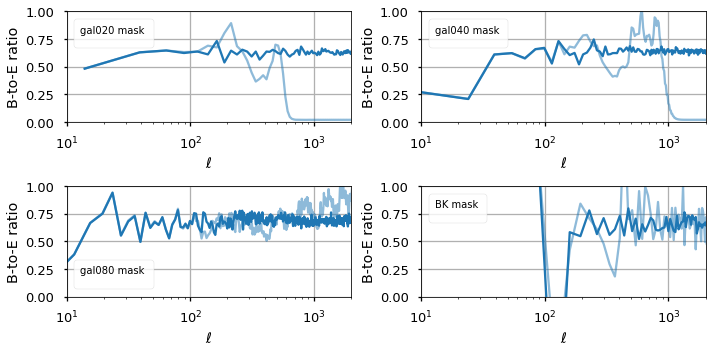

In [61]:
plt.figure(figsize=(10,5))

for jj, k in enumerate(planck_masks.keys())  :
    output_planck_mask= hp.ud_grade(planck_masks[k], nside_out=output_nside)  
    planck_mask= planck_masks[k]
    fspectra = datadir / f"dust_gnilc_hybrid_out_nside2048_float32_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        output_ell, output_cl_norm, cl_out = run_namaster(
            output_map, mask=output_planck_mask, lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=output_ell, cl_norm=output_cl_norm, **cl_out)        
        
    #else:
    #    print("run anafast on masked sky  ")
    #    output_ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)
    
    fspectra = datadir / f"dust_gnilc_varres_no_monopole_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        input_ell = np.load(fspectra)["ell"]
        cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        input_ell, input_cl_norm, cl_in  = run_namaster(
            m_planck_varres, mask=planck_mask, lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=input_ell, cl_norm=input_cl_norm, **cl_in)        
    #else:
    #    print("run anafast on masked sky  ")
    #    ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)
    plt.subplot(2,2,jj+1 )
    plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
    plt.semilogx(input_ell,   cl_in ["BB"]/cl_in["EE"], color='C%d'%0,alpha=.5,)
    plt.grid()
    plt.legend(title=(k +" mask "), fontsize=15)  
    plt.ylabel(("B-to-E ratio"))
    plt.xlabel(("$\ell$"))
    plt.ylim(0,1) 
    plt.xlim(10,2e3 ) 
    
plt.tight_layout() 

### Estimate Pol. fraction distribution 

In [62]:
get_polfrac = lambda m: np.sqrt(m[1] ** 2 + m[2] ** 2) / m[0]

In [63]:
Pout = get_polfrac(output_map)
Pin = get_polfrac(m_planck_varres.value)

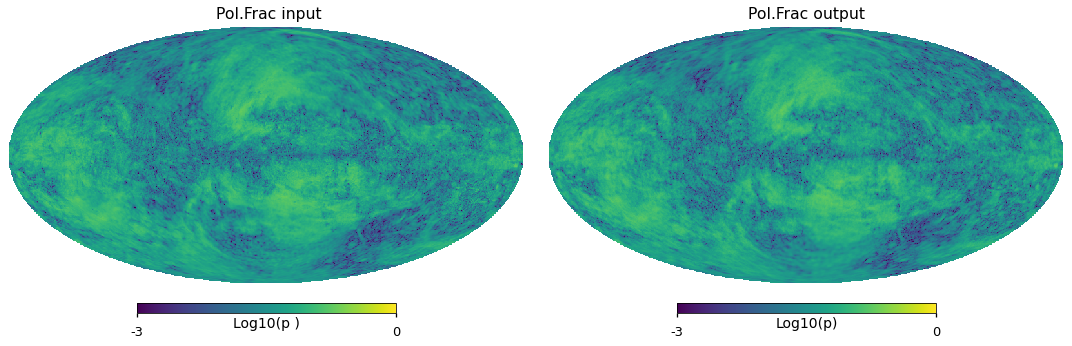

In [64]:
plt.figure(figsize=(15, 5))
hp.mollview(
    np.log10(Pin), title=" Pol.Frac input", sub=121, min=-3, max=0, unit="Log10(p )"
)
hp.mollview(
    np.log10(Pout), title="Pol.Frac output", sub=122, min=-3, max=0, unit="Log10(p)"
)

In [65]:
logpin = np.log10(Pin)
logpout = np.log10(Pout)

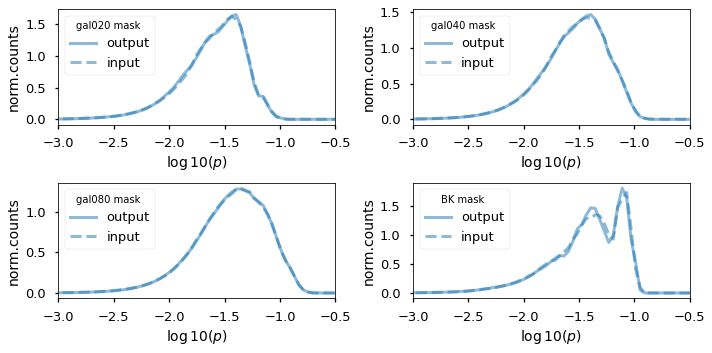

In [66]:
plt.figure(figsize=(10,5))

for jj,pm  in enumerate(planck_masks.items())  :
    k =pm[0]
    msk =pm[1] 
    
    plt.subplot(2,2,jj+1 )
    

    h,edg= np.histogram(
        logpout[msk>.5] ,
        bins=np.linspace(-4, 0, 100), density=True)
    xb = np.array([(edg[i] +edg[i+1])/2 for i in range(edg.size-1)])
    
    plt.plot( xb,h,
        lw=3,
       color='C0', alpha=.5,label='output'

    )
    h, edg= np.histogram(
        logpin[msk>.5] ,
        density=True ,
        bins=np.linspace(-4, 0, 100))  
    xb = np.array([(edg[i] +edg[i+1])/2 for i in range(edg.size-1)])
    
    plt.plot(xb,h , 
        lw=3,alpha=.5 ,color='C0' ,linestyle='--',label='input'
    )
    plt.ylabel("norm.counts", fontsize=14)
    plt.xlabel(r"$\log10( p )$", fontsize=14)
    plt.legend(title=(k +" mask "), fontsize=13, loc='best' )  
    plt.xlim(-3,-0.5)         
plt.tight_layout() 
